We'll first try with the simplest possible approach based on char-RNN that read all the excerpt and predicts in output the target complexity.

In [1]:
import numpy as np
import torch
import random
import os
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import string
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is used")

# seed everything
seed = 1
random.seed(seed)
os.environ['PYTHONASSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
#os.environ['WANDB_CONSOLE'] = 'off'

cuda is used


In [2]:
# Read the data
# Internal datasets
training = pd.read_csv('internal_train.csv').to_numpy()
test = pd.read_csv('internal_test.csv').to_numpy()
# Real datasets
blind_test = pd.read_csv('test.csv').to_numpy()
full_training = pd.read_csv('train.csv').to_numpy()

# TODO: Remove to train on full dataset
#training = training[:10, :]

training = np.random.permutation(training)
print(training.shape, test.shape, blind_test.shape, full_training.shape)

(2434, 6) (400, 6) (7, 4) (2834, 6)


In [3]:
# id,url_legal,license,excerpt,target,standard_error

# We have 5 features (id,url_legal,license,excerpt,standard_error) and 1 output 'target'

# For our model we'll only use the excerpt as a feature
training_X = training[:, 3]
training_Y = training[:, 4]
print('training shape =', training_X.shape, training_Y.shape)

full_training_X = full_training[:, 3]
full_training_Y = full_training[:, 4]
print('Real training shape =', full_training_X.shape, full_training_Y.shape)

test_X = test[:, 3]
test_Y = test[:, 4]
print('test shape =', test_X.shape, test_Y.shape)

blind_test_X = blind_test[:, 3]
print('BLIND test shape =', blind_test_X.shape)

training shape = (2434,) (2434,)
Real training shape = (2834,) (2834,)
test shape = (400,) (400,)
BLIND test shape = (7,)


In [4]:
print(training_X[0])
print('\nTarget =', training_Y[0])

I have found that when I used blood charcoal or bone coal in place of wood coal it was still more efficient; but it must be mentioned that when they are used they must be purified as follows before using: Charcoal from blood contains potash and hence it is necessary to wash it with distilled water and dry it before using it. Bone coal (also called bone black, animal charcoal, etc.) contains on an average 10 per cent. of nitrogenous and hydrogenated carbon, 8 per cent. of carbonate of lime, 78 per cent. of phosphate of lime, besides phosphate of magnesia, sulphate of lime, soluble salts, etc. Before using, it should be treated with dilute hydrochloric acid until it does not effervesce any more. The bone coal is then left to stand for 24 or 30 hours and at the end of this time is washed with distilled water until the wash water no longer reddens a blue piece of litmus paper, i.e., until every trace of hydrochloric acid has been removed from the bone coal. Wood charcoal may be treated in 

Min target = -3.676267773 | Max target = 1.711389827


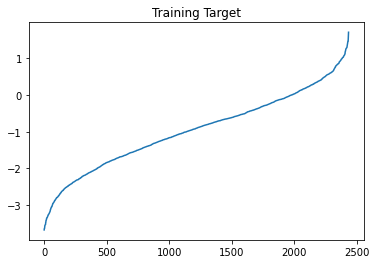

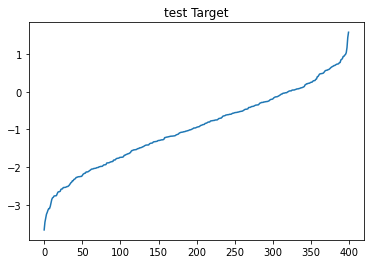

In [5]:
plt.plot(np.sort(training_Y))
plt.title('Training Target')

plt.figure()
plt.plot(np.sort(test_Y))
plt.title('test Target')
print(f'Min target = {np.min(training_Y)} | Max target = {np.max(training_Y)}')

### Turning excerpts into Tensors

To represent a single word, we'll use a custom embeddings.

To make an excerpt we join a bunch of those into a 2D matrix <n_words x 1 x embeddings_size>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [6]:
import re

# TODO: Add punctation/Upper case words

# First build the vocabulary
vocabulary = []
for excerpt in training_X:
    for word in re.sub("[^\w]", " ",  excerpt.lower()).split():
        vocabulary.append(word)

# Prob not necessary
for excerpt in full_training_X:
    for word in re.sub("[^\w]", " ",  excerpt.lower()).split():
        vocabulary.append(word)

# Expand the dictionary with the test and blind test samples
for excerpt in test_X:
    for word in re.sub("[^\w]", " ",  excerpt.lower()).split():
        vocabulary.append(word)

for excerpt in blind_test_X:
    for word in re.sub("[^\w]", " ",  excerpt.lower()).split():
        vocabulary.append(word)



# Remove duplicates
vocabulary = list(set(vocabulary))
print(len(vocabulary))
# Map from word to index
word_to_idx = {word:id for id, word in enumerate(vocabulary)}

# Turn a line of words into the curresponding indices
def lineToTensor(line):
    tensor = torch.tensor([word_to_idx[w] for w in re.sub("[^\w]", " ", line.lower()).split()], dtype=torch.long)
    return tensor

print(lineToTensor(training_X[0]))

26904
tensor([ 8478, 10093,  6888,   692, 12324,  8478, 10142,  8060, 17770,  3480,
         1998, 24440, 13338,  7888, 24224,  6289, 24440,  9731,  8904, 21923,
         4109,  8132,  6093,  9731,  4379,   776, 25958,   692, 12324,  9444,
         8561, 10142,  9444,  4379,   776, 16736, 26610, 15536,  4333, 18676,
        17770,  5351,  8060,  8989, 25954, 12191,  1177,  9731,  1039, 16397,
         9926, 26124,  9731, 14351, 12098,  3003, 12191, 16890,  9731,  4333,
        18676,  9731,  1998, 24440, 10315, 11955,  1998, 15259, 11861, 17770,
          765,  8989, 24568, 14314, 26299, 15340,  1294,  8822, 24224,  4085,
        12191,   656, 20553, 24725,  1294,  8822, 24224, 18697, 24224, 12395,
         5552,  1294,  8822, 24224, 18361, 24224, 12395, 23396, 18361, 24224,
        12829, 26075, 24224, 12395,  2996, 25618,   765,  4333, 18676,  9731,
         7371,   776,  8089, 14351, 12689, 24116,  3246, 21565,  9731, 11571,
        22725,  7533,  4877,  4109,  2939,  1998, 24440,  

In [7]:
# We want the entire dataset encoded with 1-of-k char encoding
# So, the final size will be (n_samples, 1, excerpt_length, 57) (extra dimension 1 inserted for pytorch batch)
# Since a tensor has fixed size we pad the sequences to ensure all have the same length.

# Get the max excerpt length and encode the training set
max_excerpt_len = len(max(training_X, key=len))
enc_training_X = np.zeros((training_X.shape[0], 1, max_excerpt_len,))
training_lengths = []
for i, x in enumerate(training_X):
    enc_x = lineToTensor(x)
    enc_training_X[i, 0, :enc_x.shape[0]] = torch.reshape(enc_x, (-1,))
    training_lengths.append(enc_x.shape[0])

print('encoded Training shape =',enc_training_X.shape)


max_excerpt_len = len(max(full_training_X, key=len))
enc_full_training_X = np.zeros((full_training_X.shape[0], 1, max_excerpt_len,))
full_training_lengths = []
for i, x in enumerate(full_training_X):
    enc_x = lineToTensor(x)
    enc_full_training_X[i, 0, :enc_x.shape[0]] = torch.reshape(enc_x, (-1,))
    full_training_lengths.append(enc_x.shape[0])

print('encoded Real/Full Training shape =',enc_full_training_X.shape)


max_excerpt_len = len(max(test_X, key=len))
enc_test_X = np.zeros((test_X.shape[0], 1, max_excerpt_len,))
test_lengths = []
for i, x in enumerate(test_X):
    enc_x = lineToTensor(x)
    enc_test_X[i, 0, :enc_x.shape[0]] = torch.reshape(enc_x, (-1,))
    test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_test_X.shape)


max_excerpt_len = len(max(blind_test_X, key=len))
enc_blind_test_X = np.zeros((blind_test_X.shape[0], 1, max_excerpt_len,))
blind_test_lengths = []
for i, x in enumerate(blind_test_X):
    enc_x = lineToTensor(x)
    enc_blind_test_X[i, 0, :enc_x.shape[0]] = torch.reshape(enc_x, (-1,))
    blind_test_lengths.append(enc_x.shape[0])

print('enc. Test shape =', enc_blind_test_X.shape)

encoded Training shape = (2434, 1, 1341)
encoded Real/Full Training shape = (2834, 1, 1341)
enc. Test shape = (400, 1, 1323)
enc. Test shape = (7, 1, 1144)


In [8]:
from math import floor
#Utility function to get a random sample
def randomTrainingExample():
    i = np.random.randint(0, training_X.shape[0])
    excerpt_tensor = lineToTensor(training_X[i])
    target_tensor = torch.tensor(training_Y[i], dtype=torch.float)
    return excerpt_tensor, target_tensor

randomTrainingExample()

(tensor([ 1388, 11012, 10093,  1700,  3990,   652, 14266,  9554, 19281,  6093,
          9079, 12191,  3845, 21923, 17882, 22725, 13641, 22101,  4273,  3990,
          9731,  1926, 22141, 14425, 21108,   652, 26598, 24663, 11012,  3480,
          8071,  9731, 11187,  3702,  1388, 11012,  4109, 16321,  3845,  8364,
          9926, 25725,  4109,  3990,   652, 15954, 14944,  1388, 11012,  3990,
         15052, 16886, 24224,   652,  3480, 11057,  3480, 20533, 17548, 24224,
         14298,  3480, 13357,  9926,   776,  5966,  8663,  5526, 14266, 18820,
          9554, 21519,  1958,   516, 15052,  9500, 15954, 13357,  9926, 17697,
         13338,  9554, 23515, 11818,  8071,  9444, 17882, 22725,  4019,  2939,
         18868,  1388, 11012,  6910,   692,  9444, 21007, 15052,  9500, 24766,
          9444, 19266,  9926, 17330, 21770, 12191,  3065, 11007, 14351, 11012,
         12191, 24766,   652, 26598,   776,  5646,  9926, 25078, 24926, 11012,
          1958, 21007, 15052,  9500, 12324,  9444,  

In [9]:
class CommonLitDataset(Dataset):
    # X: numpy matrix (n_samples, 1, excerpt_length,)
    def __init__(self, X, Y, lengths):
        self.X = X
        self.Y = Y
        self.lengths = lengths

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (torch.tensor(self.X[idx][0]).long(), self.lengths[idx]), torch.tensor(self.Y[idx]).float()

In [21]:
# Define the model

class LSTM(nn.Module):
    def __init__(self, hidden_dim, embedding_dim, vocab_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x, sequence_length):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, sequence_length, batch_first=True, enforce_sorted=False)
        lstm_out, (ht, ct) = self.lstm(x_pack)
        return self.linear(ht[-1])

    def initHidden(self, batch_size):
        return (torch.zeros(1, batch_size, self.hidden_dim), torch.zeros(1, batch_size, self.hidden_dim))


In [11]:
def compute_mse(model, generator):
    model.eval()
    mse = 0.0
    error = nn.MSELoss(reduction='sum')
    n = 0
    for (x, seq_len), y in generator:
        x, targets_batch = x.to(device), y.to(device)

        batch_size = x.shape[0]
        n += batch_size

        output = lstm(x, seq_len)

        targets_batch = torch.reshape(targets_batch, (batch_size, 1))

        loss = error(output, targets_batch)
        mse += loss.item()
    return mse / n

In [56]:
import time
from math import floor, inf

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
print_every = 10
plot_every = 1



BATCH_SIZE = 16     # batch = 16
hidden_dim = 256    # 256
embedding_dim = 256 # 256
epochs = 150         # 100
lr = 0.001          # 0.001
weight_decay = 1e-7 # 1e-7

# test_error = 0.829

lstm = LSTM(hidden_dim, embedding_dim, vocab_size=len(vocabulary)).to(device)

criterion = nn.MSELoss()

parameters = filter(lambda p: p.requires_grad, lstm.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset1 = CommonLitDataset(enc_training_X[400:], training_Y[400:], training_lengths[400:])
training_generator = torch.utils.data.DataLoader(commonlit_dataset1, **params)

commonlit_dataset2 = CommonLitDataset(enc_training_X[:400], training_Y[:400], training_lengths[:400])
validation_generator = torch.utils.data.DataLoader(commonlit_dataset2, **params)

# Early stopping logic
val_losses = []
best_val_error = inf
best_val_epoch = 0

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    lstm.train()
    for (x, seq_len), y in training_generator:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = lstm(x, seq_len)

        loss = criterion(y_pred, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total

    current_val_error = compute_mse(lstm, validation_generator)
    val_losses.append(current_val_error)
    if current_val_error < best_val_error:
        best_val_error = current_val_error
        best_val_epoch = iter
        # TODO: Implement patience

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) MSE = %.4f Val MSE = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss, current_val_error))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 10 | 10% (0m 36s) MSE = 0.1340 Val MSE = 0.9964
Iteration 20 | 20% (1m 15s) MSE = 0.0699 Val MSE = 1.0030
Iteration 30 | 30% (1m 55s) MSE = 0.0531 Val MSE = 0.9455
Iteration 40 | 40% (2m 34s) MSE = 0.0386 Val MSE = 0.8386
Iteration 50 | 50% (3m 13s) MSE = 0.0291 Val MSE = 0.8159
Iteration 60 | 60% (3m 52s) MSE = 0.0258 Val MSE = 0.8093
Iteration 70 | 70% (4m 33s) MSE = 0.0202 Val MSE = 0.7874
Iteration 80 | 80% (5m 11s) MSE = 0.0194 Val MSE = 0.7760
Iteration 90 | 90% (5m 50s) MSE = 0.0153 Val MSE = 0.7653
Iteration 100 | 100% (6m 28s) MSE = 0.0146 Val MSE = 0.7324


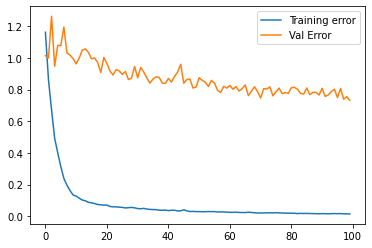

In [57]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses, label='Training error')
plt.plot(val_losses, label='Val Error')
plt.legend()

## Retrain the model on the full train dataset

In [58]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': 0}

commonlit_dataset3 = CommonLitDataset(enc_full_training_X, full_training_Y, full_training_lengths)
full_training_generator = torch.utils.data.DataLoader(commonlit_dataset3, **params)

final_model = LSTM(hidden_dim, embedding_dim, vocab_size=len(vocabulary)).to(device)

epochs = best_val_epoch

criterion = nn.MSELoss()

all_losses = []

start = time.time()

parameters = filter(lambda p: p.requires_grad, final_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=lr)

for iter in range(1, epochs + 1):
    total = 0
    current_loss = 0.0
    final_model.train()
    for (x, seq_len), y in training_generator: # TODO: Change in full_training_generator (to include the test data)
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = final_model(x, seq_len)

        loss = criterion(y_pred, y.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*y.shape[0]
        total += y.shape[0]

    # Mean squared error
    current_loss /= total

    # Print iter number, loss
    if iter % print_every == 0:
        print('Iteration %d | %d%% (%s) MSE = %.4f' % (iter, iter / epochs * 100, timeSince(start), current_loss))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

Iteration 10 | 10% (0m 32s) MSE = 0.1301
Iteration 20 | 20% (1m 6s) MSE = 0.0657
Iteration 30 | 30% (1m 38s) MSE = 0.0531
Iteration 40 | 40% (2m 10s) MSE = 0.0389
Iteration 50 | 50% (2m 45s) MSE = 0.0342
Iteration 60 | 60% (3m 21s) MSE = 0.0279
Iteration 70 | 70% (3m 56s) MSE = 0.0227
Iteration 80 | 80% (4m 31s) MSE = 0.0188
Iteration 90 | 90% (5m 6s) MSE = 0.0197
Iteration 100 | 100% (5m 42s) MSE = 0.0161


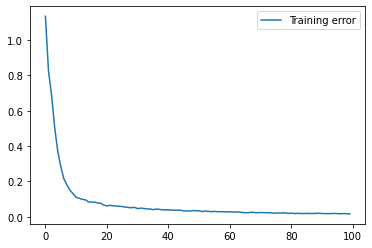

In [59]:
# Plot the learning curve
plt.figure()
plt.plot(all_losses, label='Training error')
plt.legend()

## Evaluate the model

In [60]:
test_params = {'batch_size': 64,
          'shuffle': False,
          'num_workers': 0}

internal_test_dataset = CommonLitDataset(enc_test_X, test_Y, test_lengths)
test_generator = torch.utils.data.DataLoader(internal_test_dataset, **test_params)


blind_test_params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 0}

blind_test_dataset = CommonLitDataset(enc_blind_test_X, np.zeros(enc_blind_test_X.shape), blind_test_lengths)
blind_test_generator = torch.utils.data.DataLoader(blind_test_dataset, **blind_test_params)

In [61]:
# Compute the final MSE on the training set
def compute_squared_error(generator):
    error = nn.MSELoss(reduction='sum')
    with torch.no_grad():
        mse = 0.0
        for (x, seq_len), targets_batch in generator:
            x, targets_batch = x.to(device), targets_batch.to(device)

            batch_size = x.shape[0]

            output = final_model(x, seq_len)

            targets_batch = torch.reshape(targets_batch, (batch_size, 1))

            loss = error(output, targets_batch)
            mse += loss.item()
    return mse
print('Training RMSE =', np.sqrt(compute_squared_error(training_generator) / enc_training_X.shape[0]))
# A bit useless since we train also on this data
print('Internal TEST RMSE =', np.sqrt(compute_squared_error(test_generator) / enc_test_X.shape[0]))
    

Training RMSE = 0.11486371621159631
Internal TEST RMSE = 0.829654770545024


# Compute blind test set outputs

In [28]:
outputs = []
with torch.no_grad():
    for i, ((x, seq_len), targets_batch) in enumerate(blind_test_generator):
        excerpts_batch = x.to(device)

        batch_size = excerpts_batch.shape[0]

        output = final_model(excerpts_batch, seq_len)
        id = blind_test[i, 0]
        print(id, output.item())
        outputs.append((id, output.item()))

# Save outputs to submission.csv
if False:
    with open('submission.csv', 'w') as f:
        f.write('id,target\n')
        for id, o in outputs:
            f.write(id+','+o+'\n')

c0f722661 -1.0180059671401978
f0953f0a5 -1.0058928728103638
0df072751 -0.4917626976966858
04caf4e0c -1.1692789793014526
0e63f8bea -0.9193040728569031
12537fe78 -0.35978007316589355
965e592c0 -0.24307191371917725


 NEXT:

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
 
 
 
    Try the nn.LSTM and nn.GRU layers
    Combine multiple of these RNNs as a higher level network
